# Notebook 22: Analysis through He burning

In this notebook we look at a few variations of stars run through Helium burning. The stopping condition is the central He4 fraction dropping below $10^{-6}$, which also allows for carbon ignition.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 22

## Imports

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
PROJECT_FOLDER = ROOT/'mesa/sse_wind_test'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [5]:
ZSUN = 0.014

### Utilities

In [6]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [7]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [8]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [9]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication and division."""
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [11]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
            except:
                continue
            else:
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

### Winds

In [12]:
def _sanders_winds(l, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l < l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
        
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [13]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [14]:
vink2001_test_teffs = np.logspace(3, 6, 100)
vink2001_test_mdots = vink2001_winds(1e6, vink2001_test_teffs, 60, ZSUN)

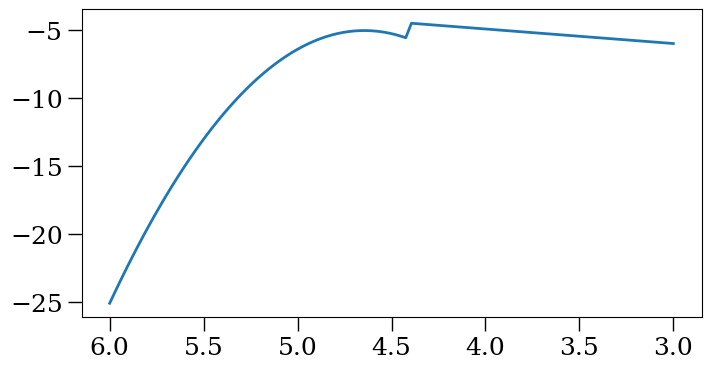

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.log10(vink2001_test_teffs), np.log10(vink2001_test_mdots))
ax.invert_xaxis()

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## Humphreys-Davidson limit

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

# Analysis

Models run through helium burning are identified by a first digit 1 in the project folder. All use $Y_0=0.4$ and $\delta Y=0.3$.

In [195]:
model_ids = ['10', '12', '13', '11', '14']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$65\,\\mathrm{M}_\\odot,\\,Z_\\odot/10$',
    '$65\,\\mathrm{M}_\\odot,\\,Z_\\odot/15$',
    '$50\,\\mathrm{M}_\\odot,\\,Z_\\odot/15$',
    '$40\,\\mathrm{M}_\\odot,\\,Z_\\odot/15$',
    '$40\,\\mathrm{M}_\\odot,\\,Z_\\odot/15,\\Delta_\\mathrm{mesh}=1$',    
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/10_m65_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/12_m65_0066zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/13_m50_0066zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/11_m40_0066zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/14_1meshdelta_m40_0066zsun_04y0_03dy_HeExh


Let's check the stellar models available.

In [196]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/10_m65_01zsun_04y0_03dy_HeExh:
		(m1/msun) 65.0:
			(p_orb/d) 0.80
			(p_orb/d) 1.00
			(p_orb/d) 1.19
			(p_orb/d) 1.40
			(p_orb/d) 1.82
			(p_orb/d) 2.20
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/12_m65_0066zsun_04y0_03dy_HeExh:
		(m1/msun) 65.0:
			(p_orb/d) 0.61
			(p_orb/d) 0.80
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.40
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/13_m50_0066zsun_04y0_03dy_HeExh:
		(m1/msun) 50.0:
			(p_orb/d) 0.61
			(p_orb/d) 0.80
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.40
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/11_m40_0066zsun_04y0_03dy_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.61
			(p_orb/d) 0.80
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.40
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/14_1meshdelta_m40_0066zsun_04y0_03dy_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.61
			(p_orb/d) 0.80
			(p_orb/d) 1.

## The effect of resolution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


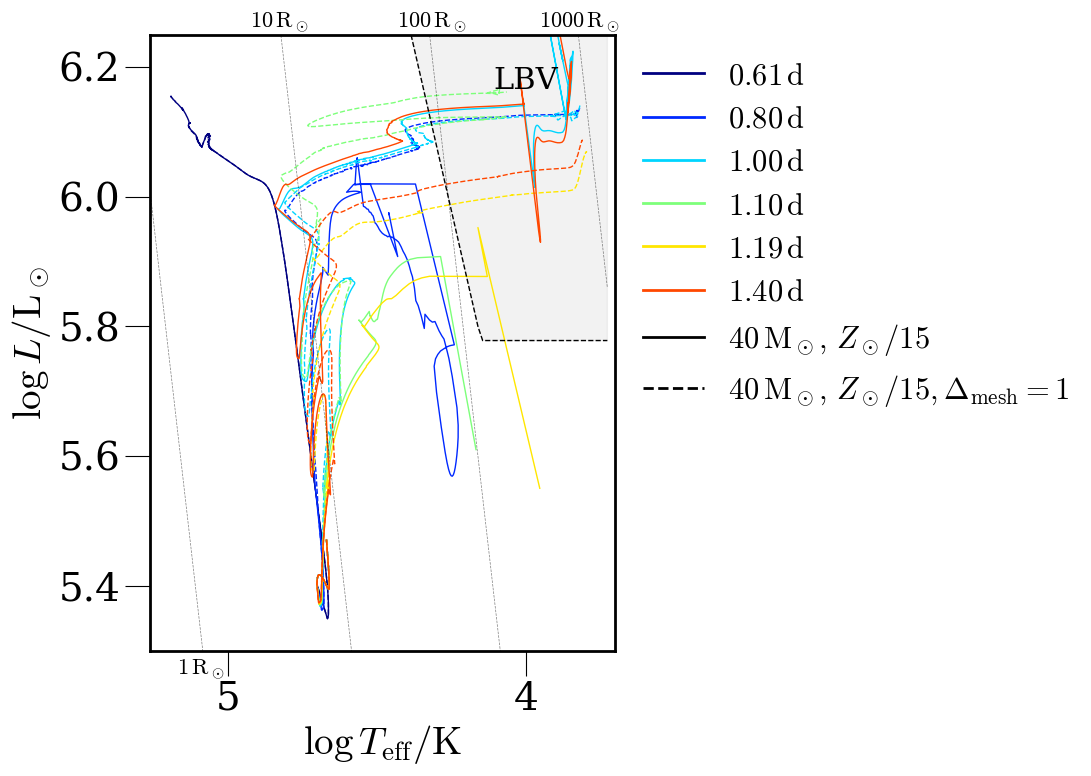

In [199]:

fig, ax = plt.subplots(figsize=(6, 8))

# Plot 1, Zsun/10

models_to_plot = [3, 4]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--']

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)



ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

# GUIDELINES

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Humphreys-Davidson limit and LBV regime
hd_x = np.linspace(*xlim, 100)
hd_y = hd_limit(hd_x)
ax.plot(hd_x, hd_y, 'k--', lw=1)
ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)
ax.text(4, 6.2, 'LBV', ha='center', va='top', fontsize=22, transform=ax.transData)

xlim = (xlim[0], 3.7)
ylim = (5.3, 6.25)

ax.set_xlim(xlim[0], 3.7)
ax.set_ylim(5.3, 6.25)

# Lines of constant radius
r = 1
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='top', fontsize=16)
r = 10
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 100
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 1000
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)



savefig(fig, 'hr_allp_meshdelta_comparison')

## The effect of metallicity

The Sanders WR wind prescription is sensitive to metallicity, its lower luminosity limit in particular. This means that metallicity plays a strong role in setting not only how much mass loss will occurs over the stars' lifetime, but also for what minimum luminosity --- or minimum mass --- winds will effectively cease (considering that low-luminosity WR winds or MS wind will not incurr considerable mass loss).

We will compare models 10 and 12, both for a $65\,\mathrm{M}_\odot$ star with different initial spin periods. Their settings are all the same, except for metallicity, which is $\mathrm{Z}_\odot/10$ for 10 and $\mathrm{Z}_\odot/15$ for 11. We look first at their tracks on the HR diagram.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


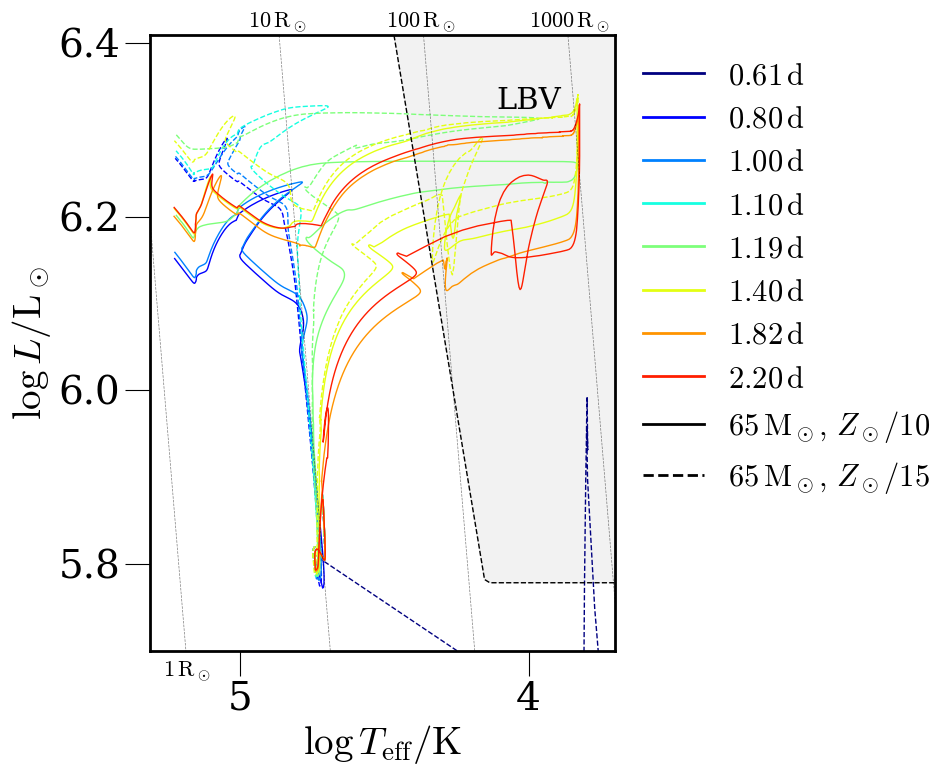

In [198]:

fig, ax = plt.subplots(figsize=(6, 8))

# Plot 1, Zsun/10

models_to_plot = [0, 1]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--']

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)



ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

# GUIDELINES

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Humphreys-Davidson limit and LBV regime
hd_x = np.linspace(*xlim, 100)
hd_y = hd_limit(hd_x)
ax.plot(hd_x, hd_y, 'k--', lw=1)
ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)
ax.text(4, 6.35, 'LBV', ha='center', va='top', fontsize=22, transform=ax.transData)

# Lines of constant radius
r = 1
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-5.7))], 5.7-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='top', fontsize=16)
r = 10
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 100
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 1000
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)

ax.set_xlim(xlim[0], 3.7)
ax.set_ylim(5.7, ylim[1])

savefig(fig, 'hr_allp_metallicity_comparison')

It looks like all the models that break where already not-CHE before they started to run into problems, which should be fine. However, we have cases like $0.8\,\mathrm{d}$, which goes CHE for the higher metallicity, but nor the lower. Is this not the opposite of what is expected? Let's see what is going on with the winds in the two $0.8\,\mathrm{d}$ models. 

For $\mathrm{Z}_\odot/10$

In [95]:
wind_test_model = model_dicts[0]['65.0']['0.80']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014/10

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_648214/3179152259.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_648214/3179152259.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


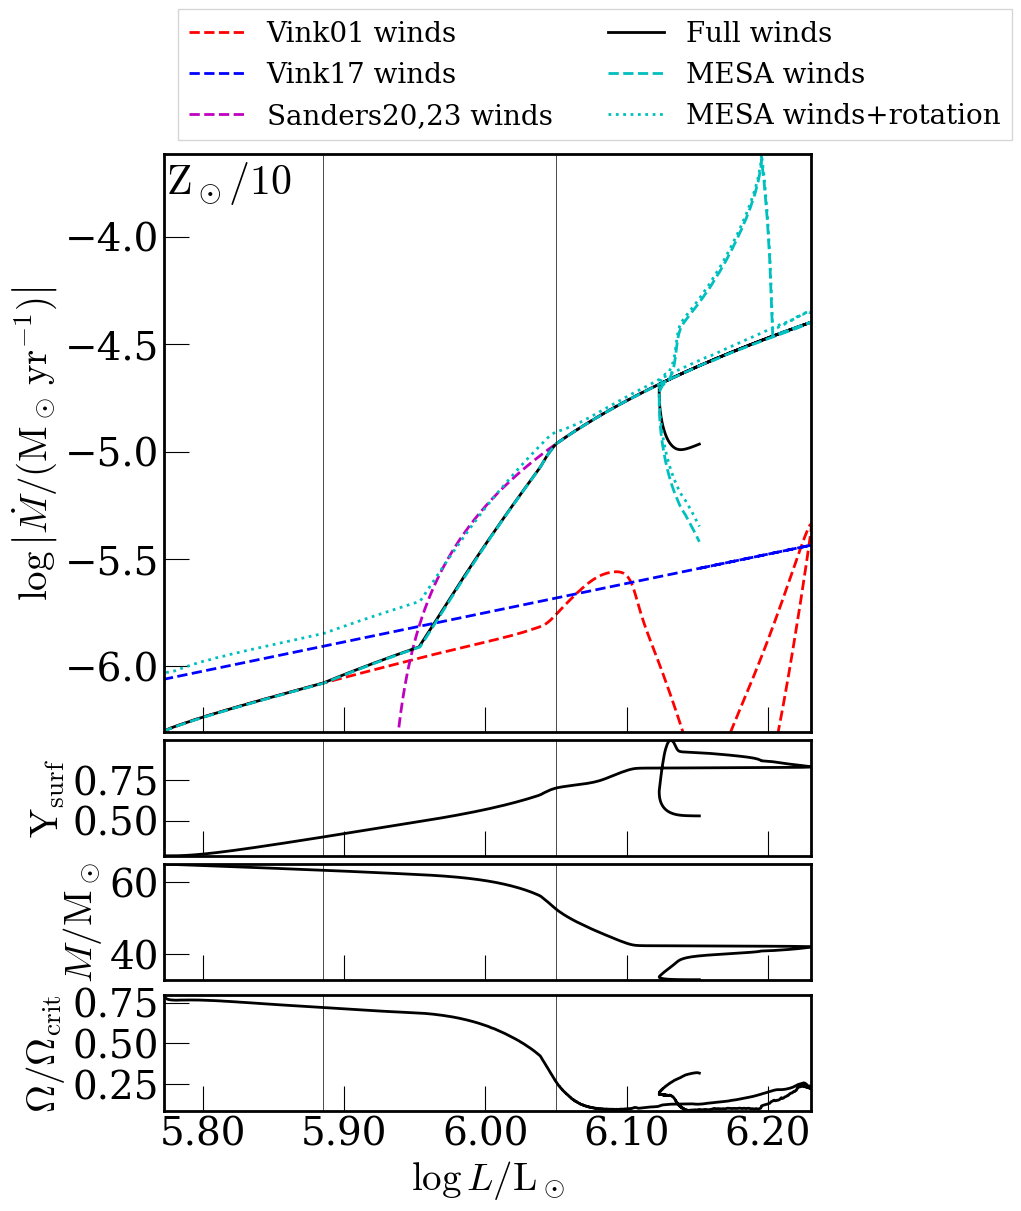

In [96]:

fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m65_p080_zsun_div_10')

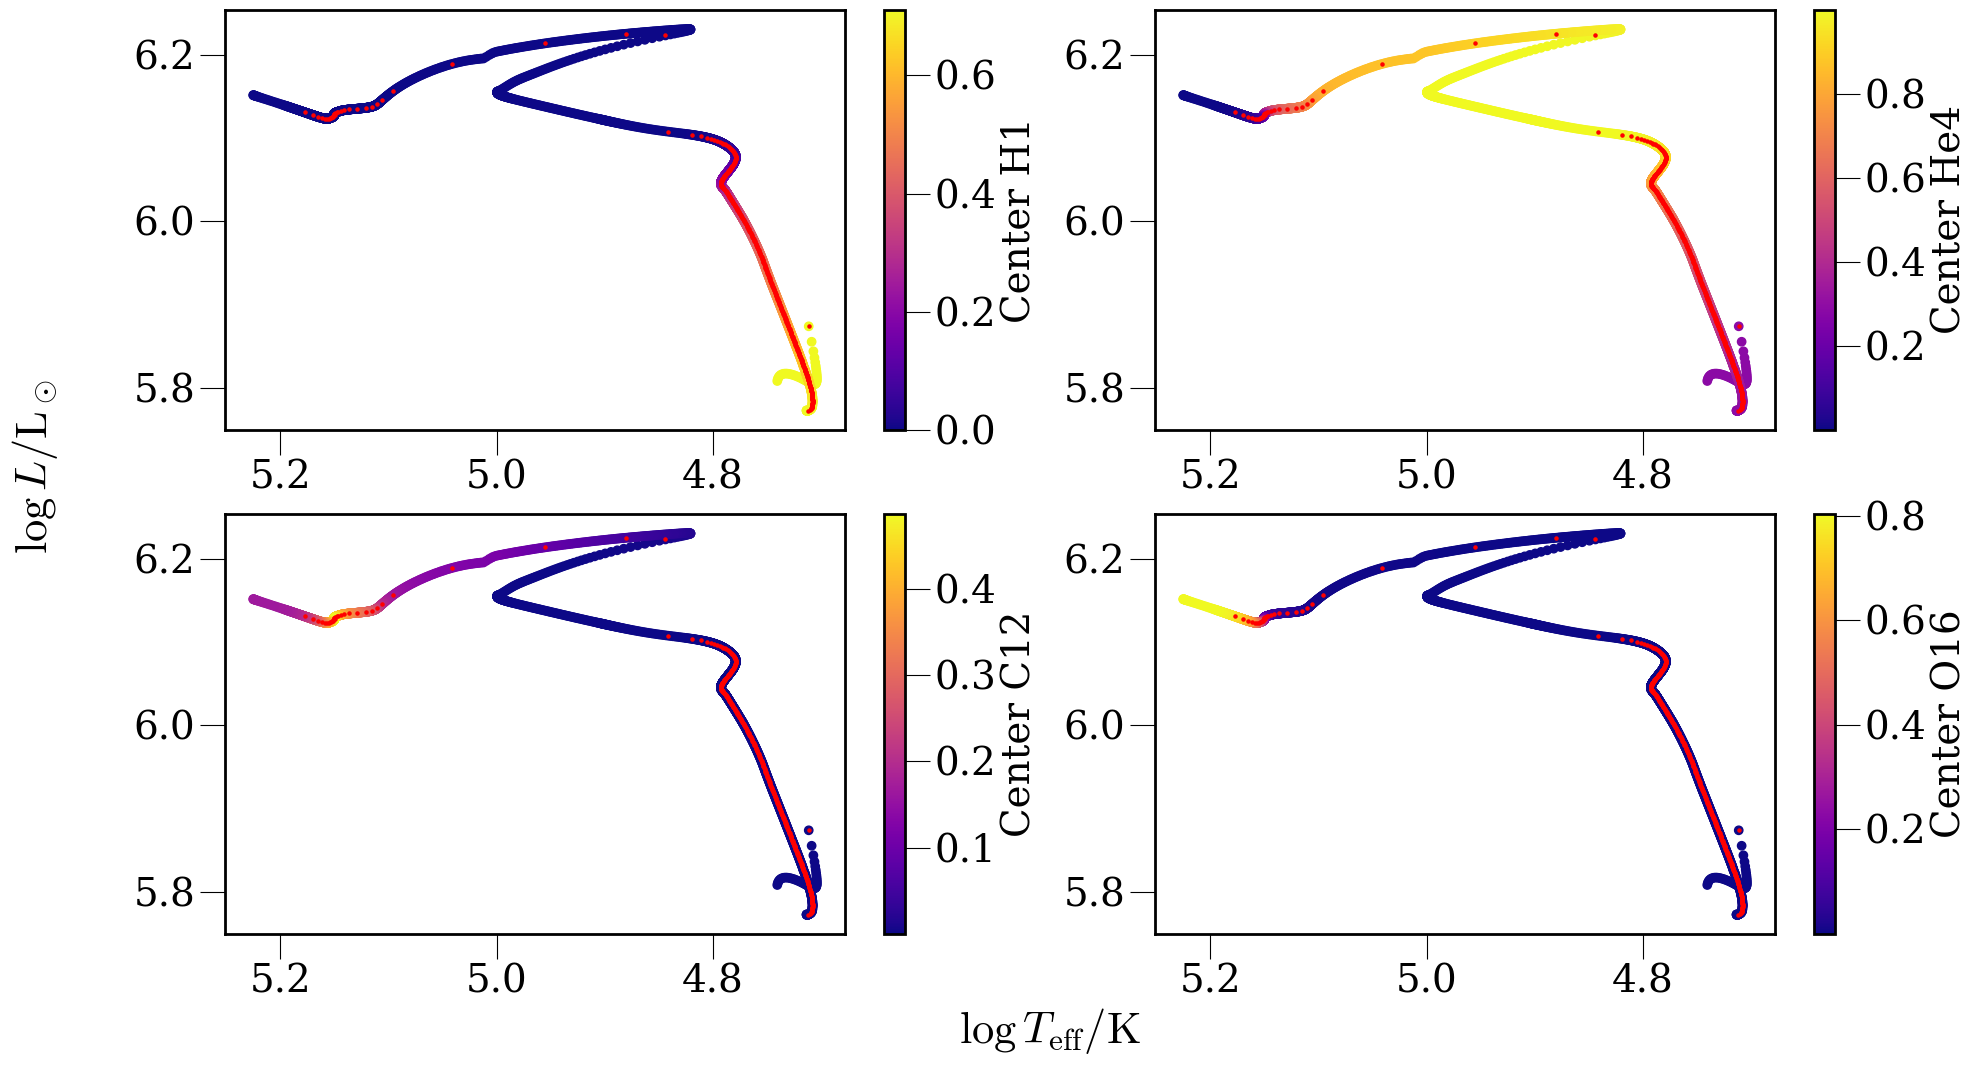

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
ages_to_mark = np.arange(0, 4500, 10) * 1e3
star_ages = h.star_age
agemarker_indices = [np.argmin(np.abs(age-star_ages)) for age in ages_to_mark]
agemarker_logl = h.log_L[agemarker_indices]
agemarker_logteff = h.log_Teff[agemarker_indices]
for ax in axes.flatten():
    ax.scatter(agemarker_logteff, agemarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

savefig(fig, 'composition_hr_agemarkers_m65_p080_zsun_div_10')

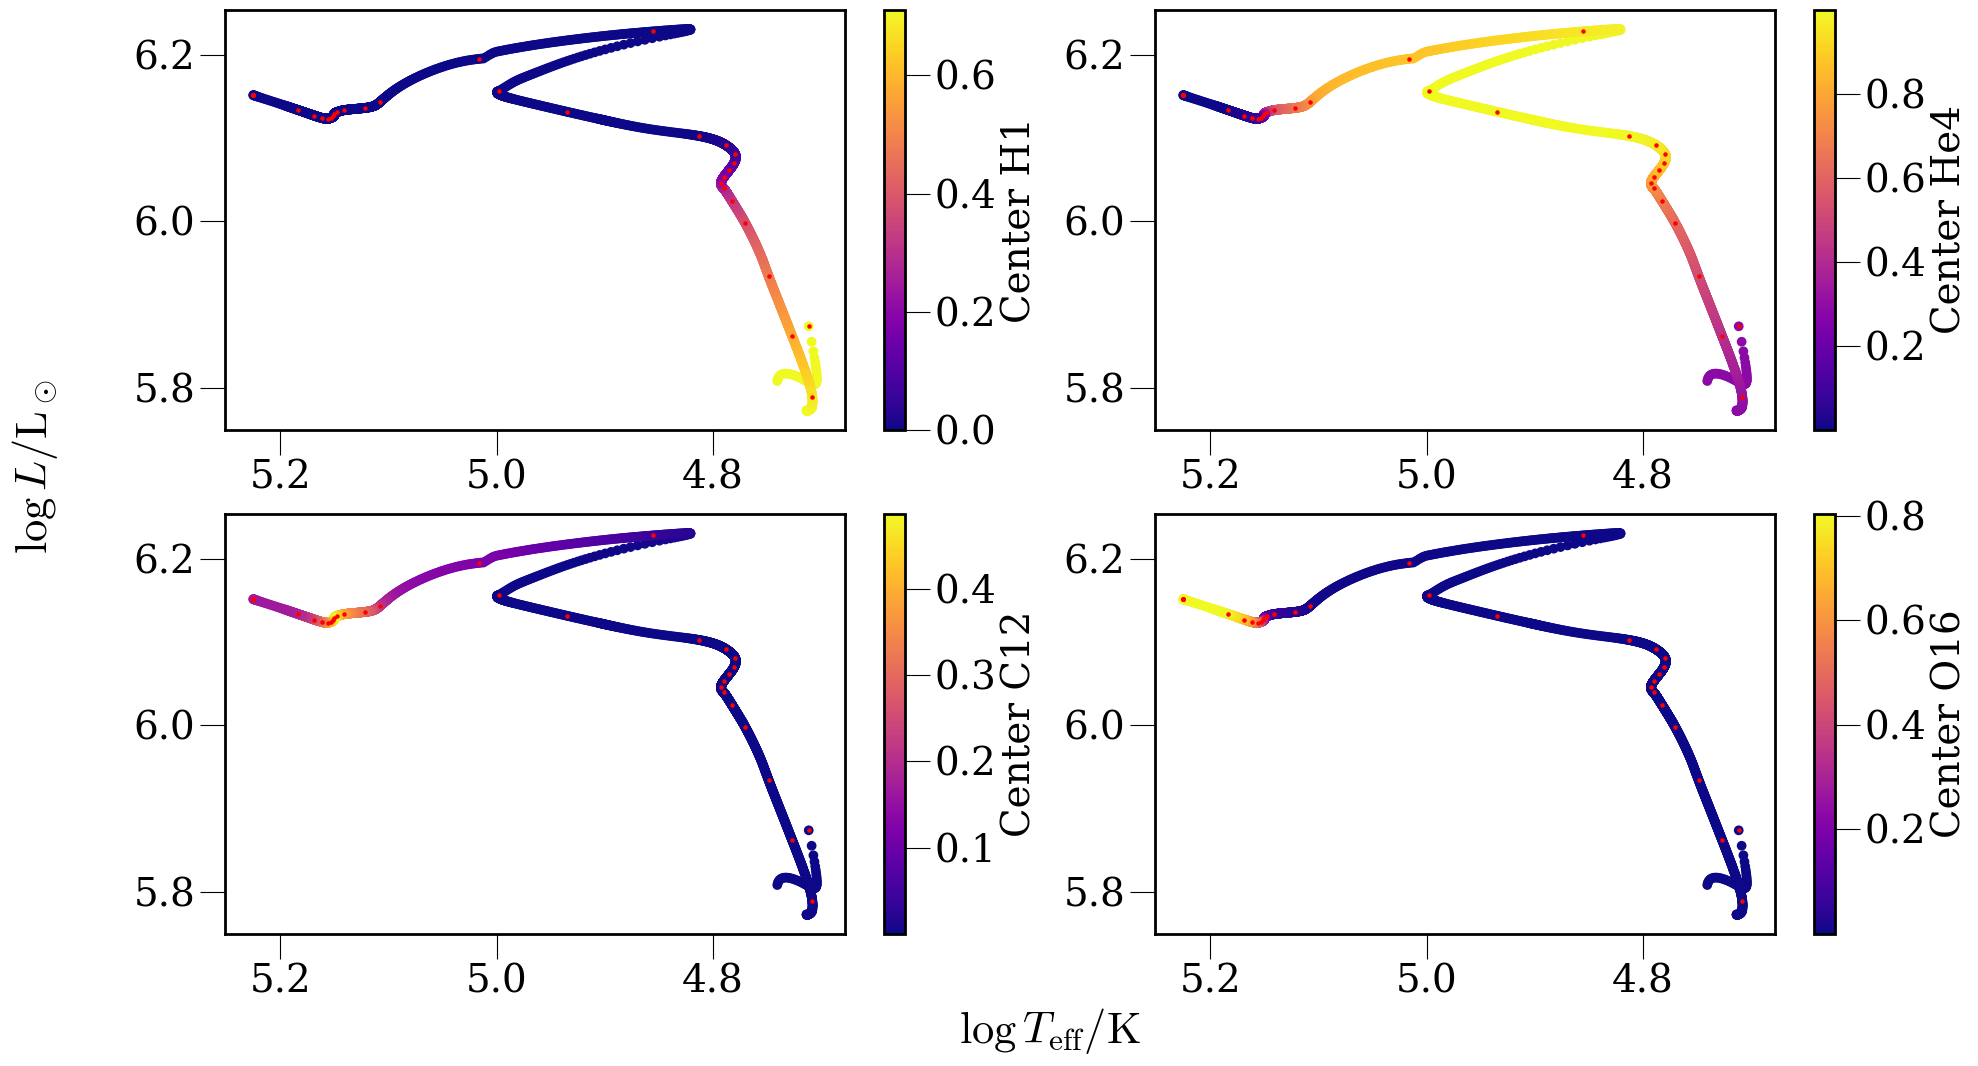

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number
modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

savefig(fig, 'composition_hr_modelmarkers_m65_p080_zsun_div_10')

In [81]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[0]['65.0']['0.80']/'LOGS'))
#mm.scrubHistory()

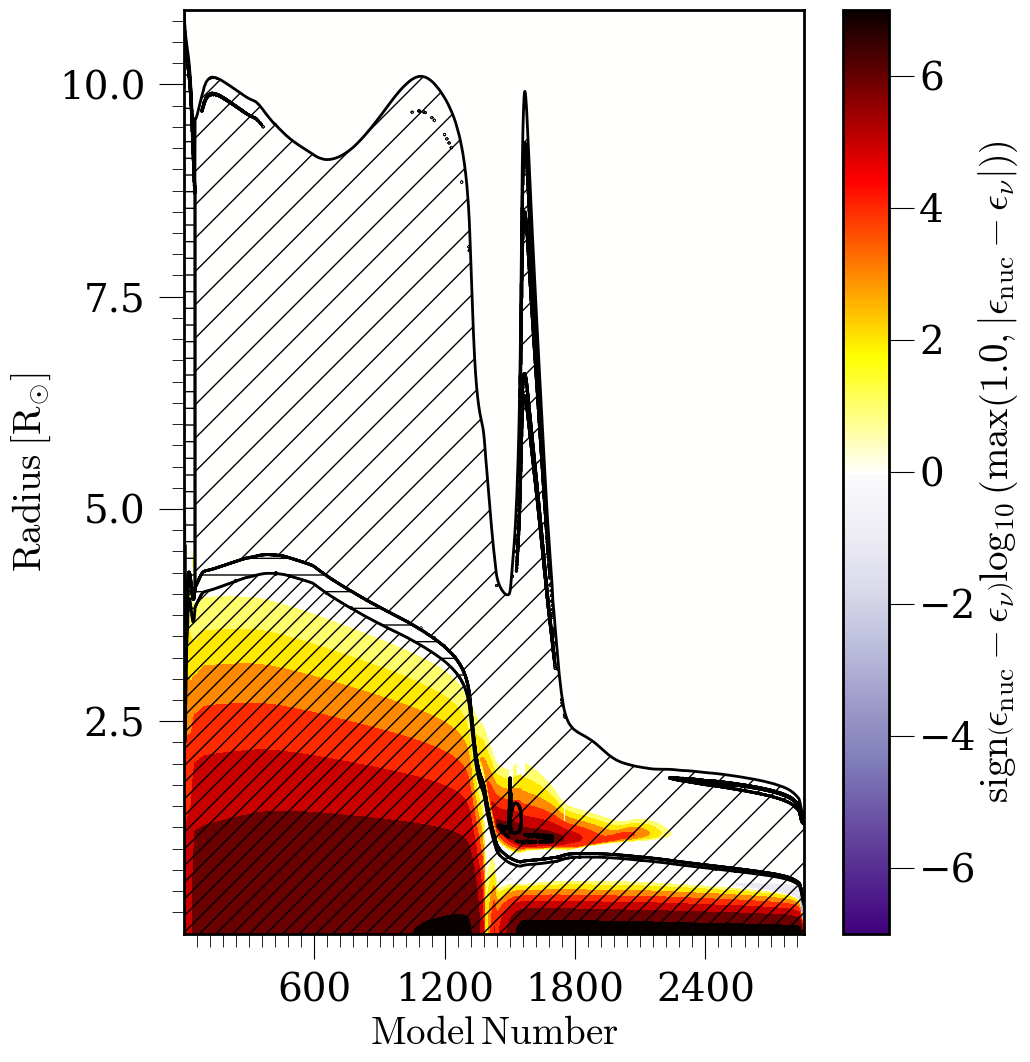

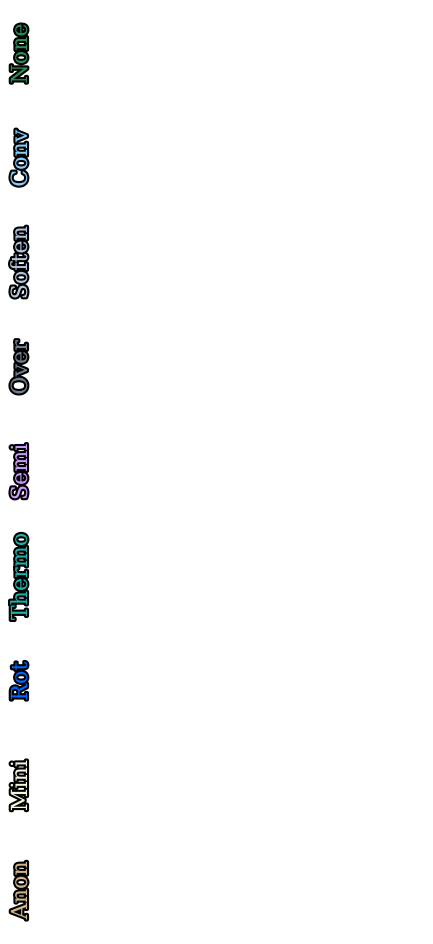

(0.0001, 10.880975734815442)

In [82]:
fig, ax = plt.subplots(figsize=(10,12))

p = mp.plot()
p.plotKip(mm, show_mix=True, mix_hatch=True, step=1, ax=ax, yaxis='radius')
ylim = ax.get_ylim()

for model_n in model_numbers:
    ax.vlines(model_n, ylim[0], ylim[-1], color='m')
    
ax.set_ylim(ylim)

In [88]:
0.014/15

0.0009333333333333333

In [89]:
wind_test_model = model_dicts[1]['65.0']['0.80']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.0009

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_648214/1539930803.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_648214/1539930803.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


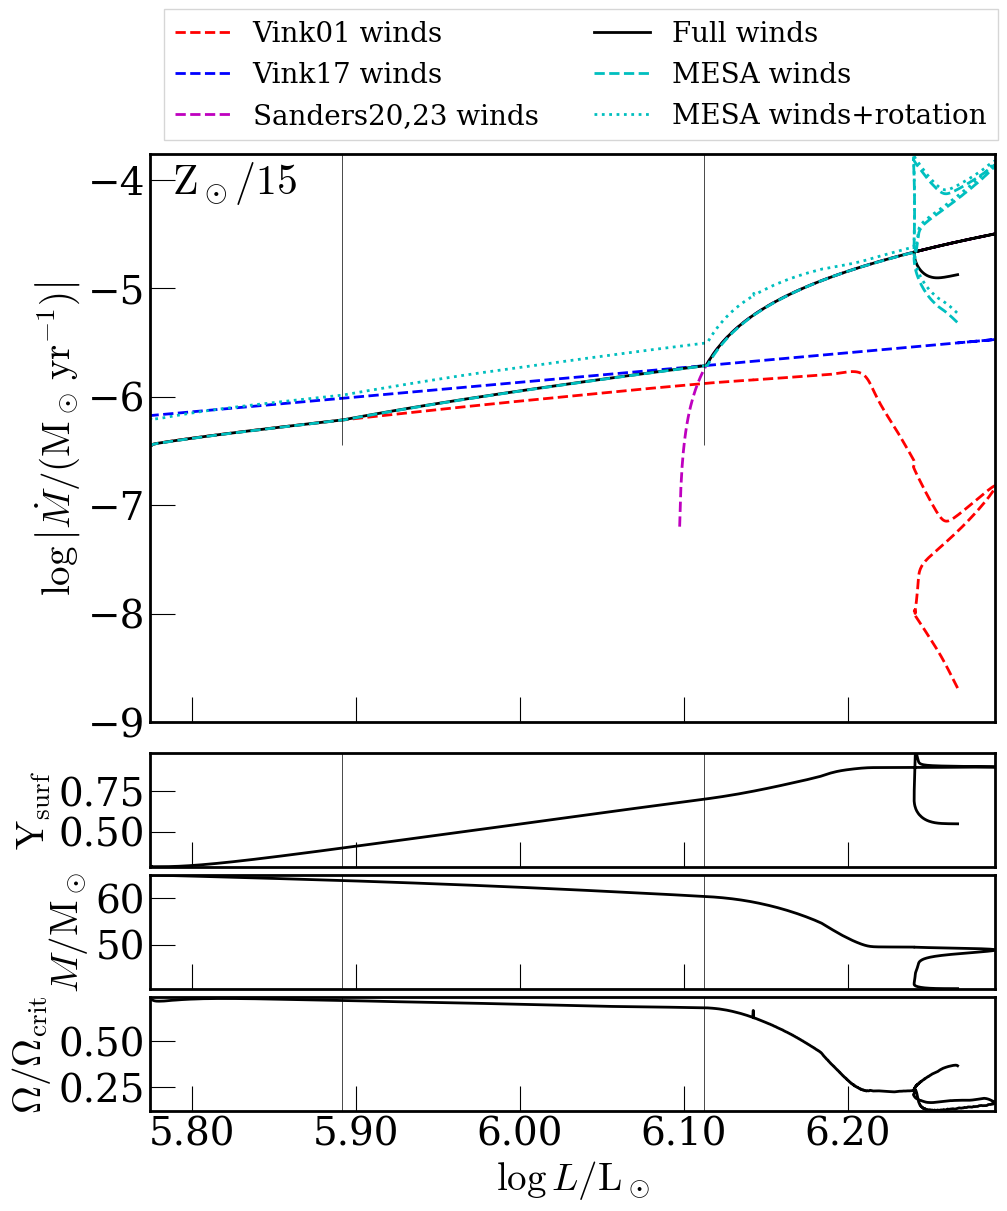

In [90]:

fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(-9, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/15$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m65_p080_zsun_div_15')

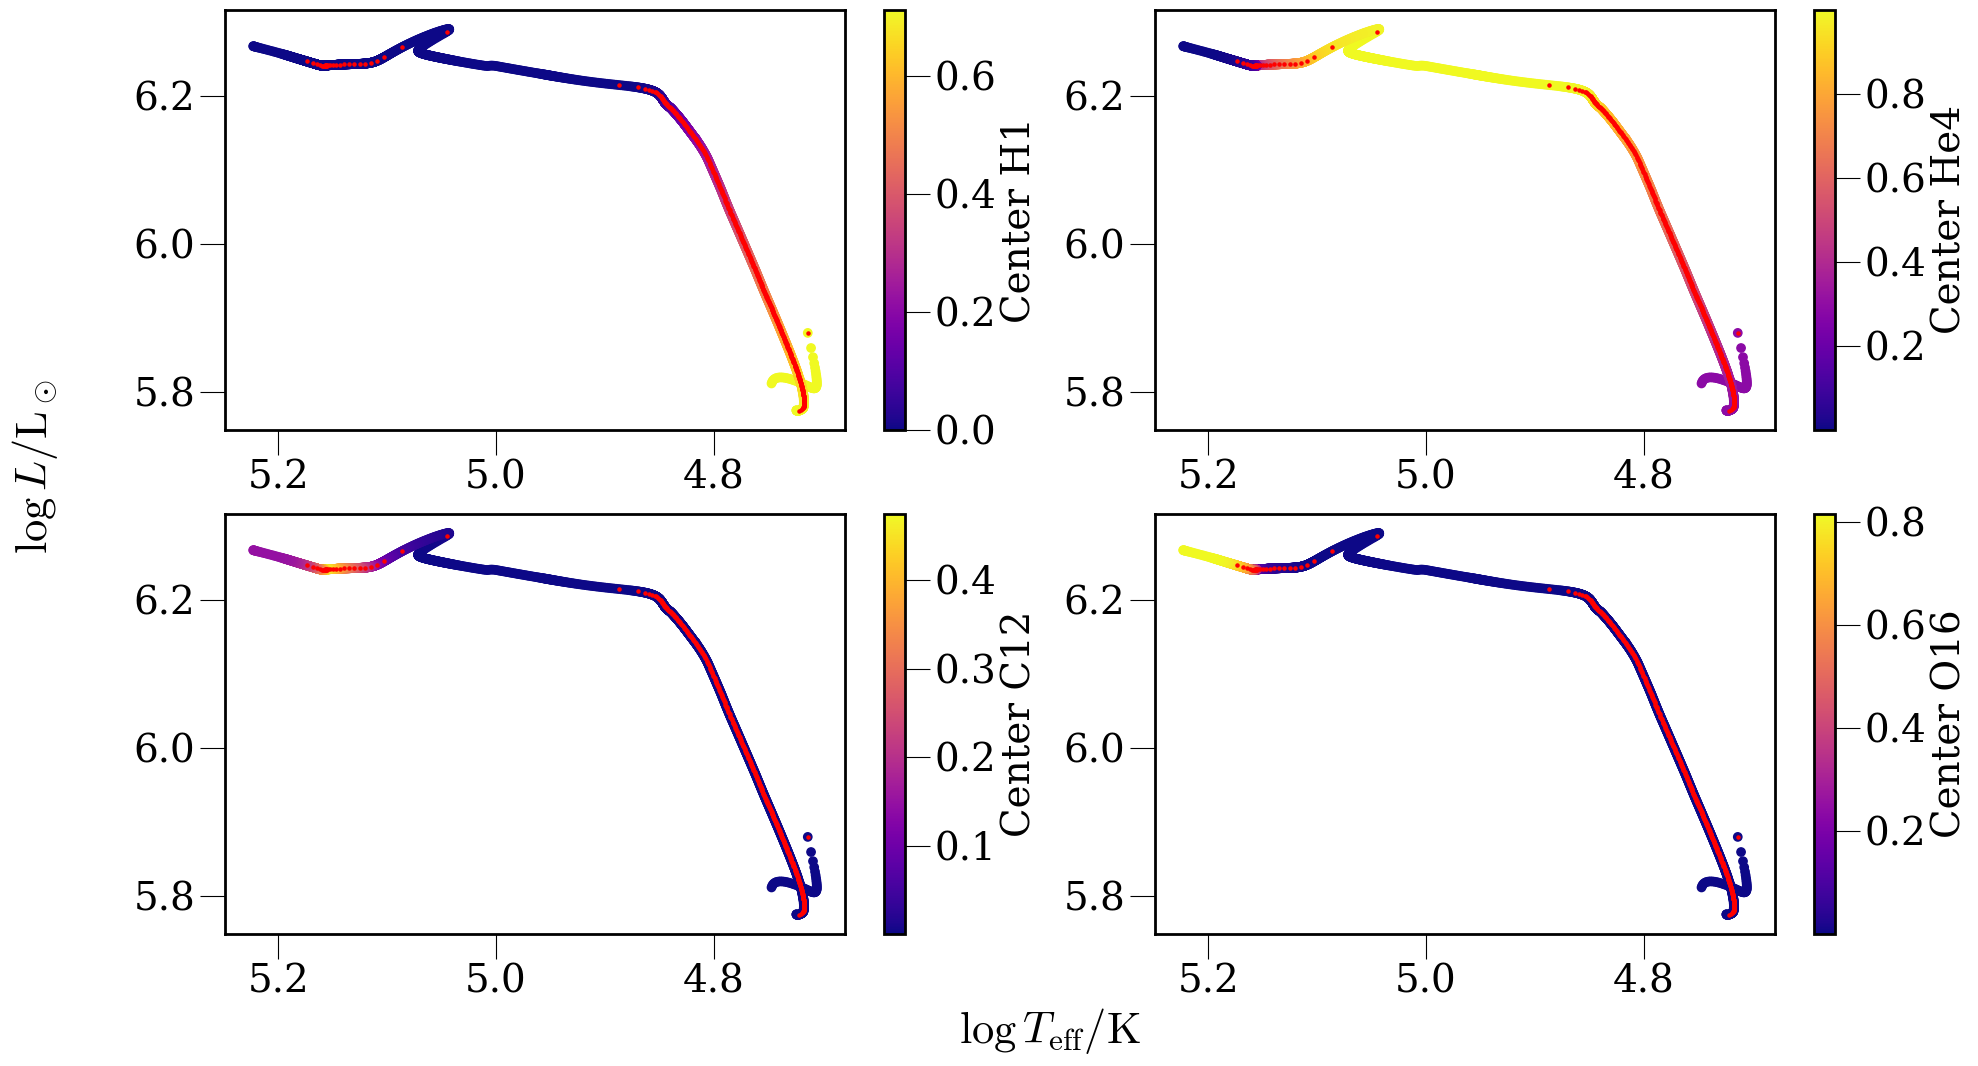

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
ages_to_mark = np.arange(0, 4500, 10) * 1e3
star_ages = h.star_age
agemarker_indices = [np.argmin(np.abs(age-star_ages)) for age in ages_to_mark]
agemarker_logl = h.log_L[agemarker_indices]
agemarker_logteff = h.log_Teff[agemarker_indices]
for ax in axes.flatten():
    ax.scatter(agemarker_logteff, agemarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

savefig(fig, 'composition_hr_agemarkers_m65_p080_zsun_div_15')

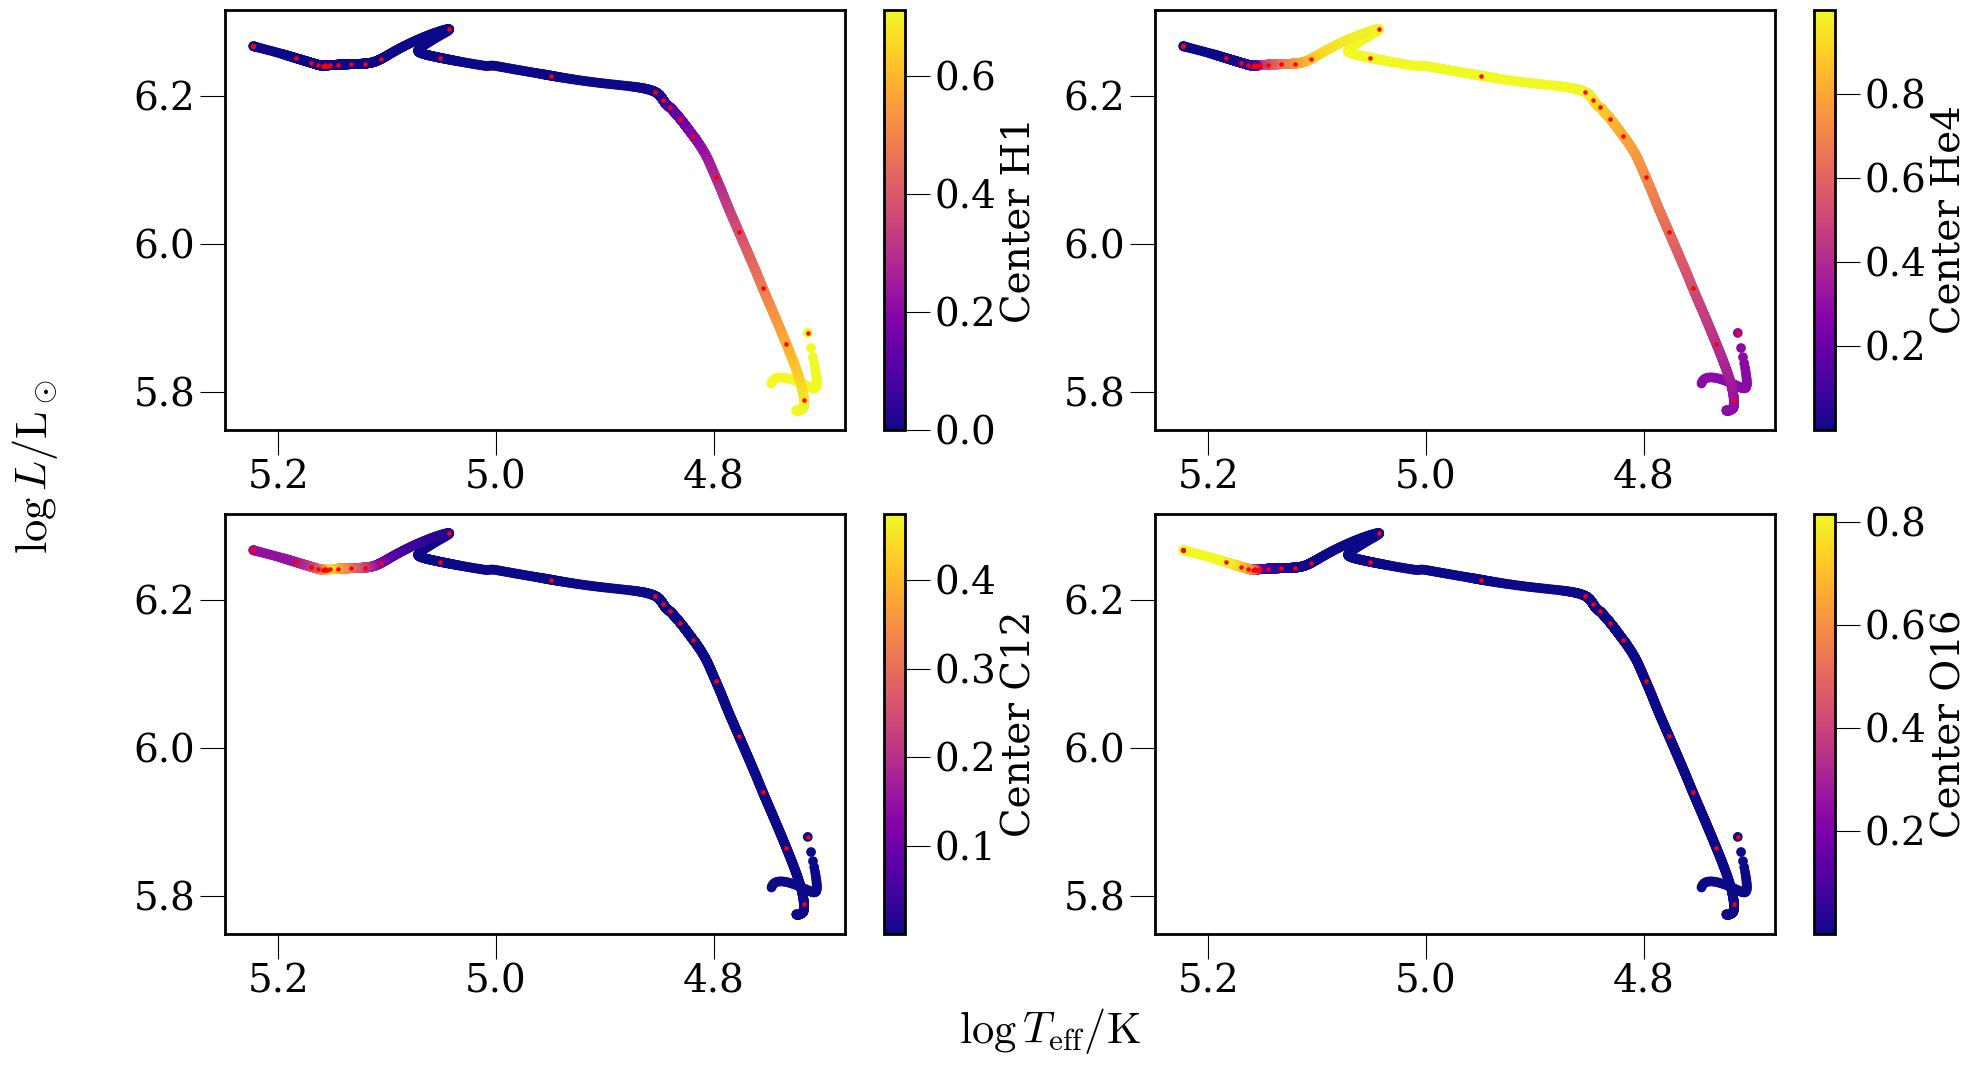

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
models_to_mark = np.arange(0, 4000, 100)
model_numbers = h.model_number
modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

savefig(fig, 'composition_hr_modelmarkers_m65_p080_zsun_div_15')

In [93]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[1]['65.0']['0.80']/'LOGS'))
#mm.scrubHistory()

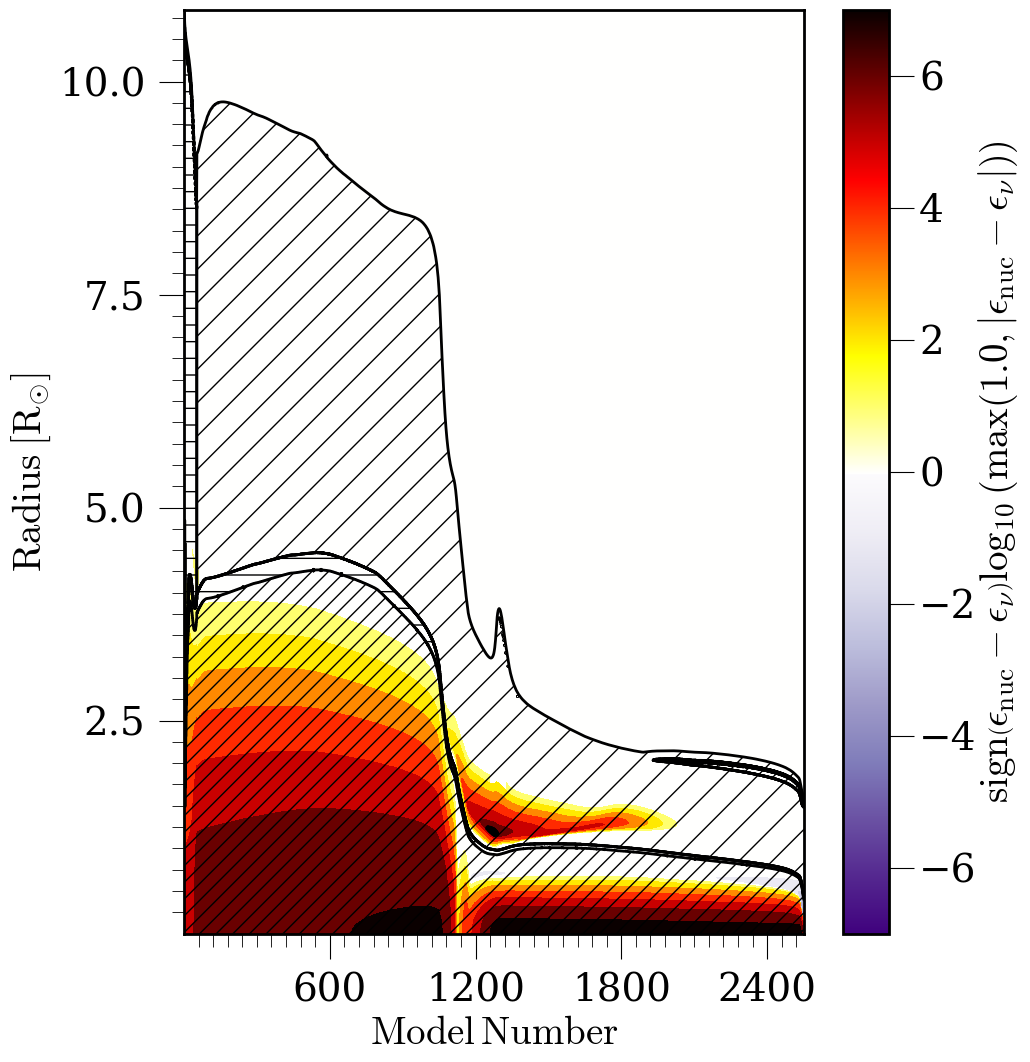

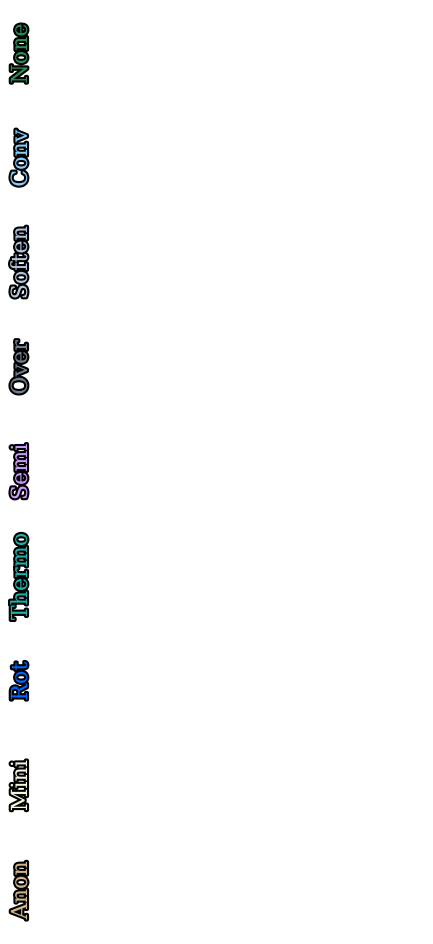

(0.0001, 10.84461936953932)

In [94]:
fig, ax = plt.subplots(figsize=(10,12))

p = mp.plot()
p.plotKip(mm, show_mix=True, mix_hatch=True, step=1, ax=ax, yaxis='radius')
ylim = ax.get_ylim()

for model_n in model_numbers:
    ax.vlines(model_n, ylim[0], ylim[-1], color='m')
    
ax.set_ylim(ylim)

## Core spin-down


In [120]:
test_case = model_dicts[0]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(0.0, 68.24999812351741)

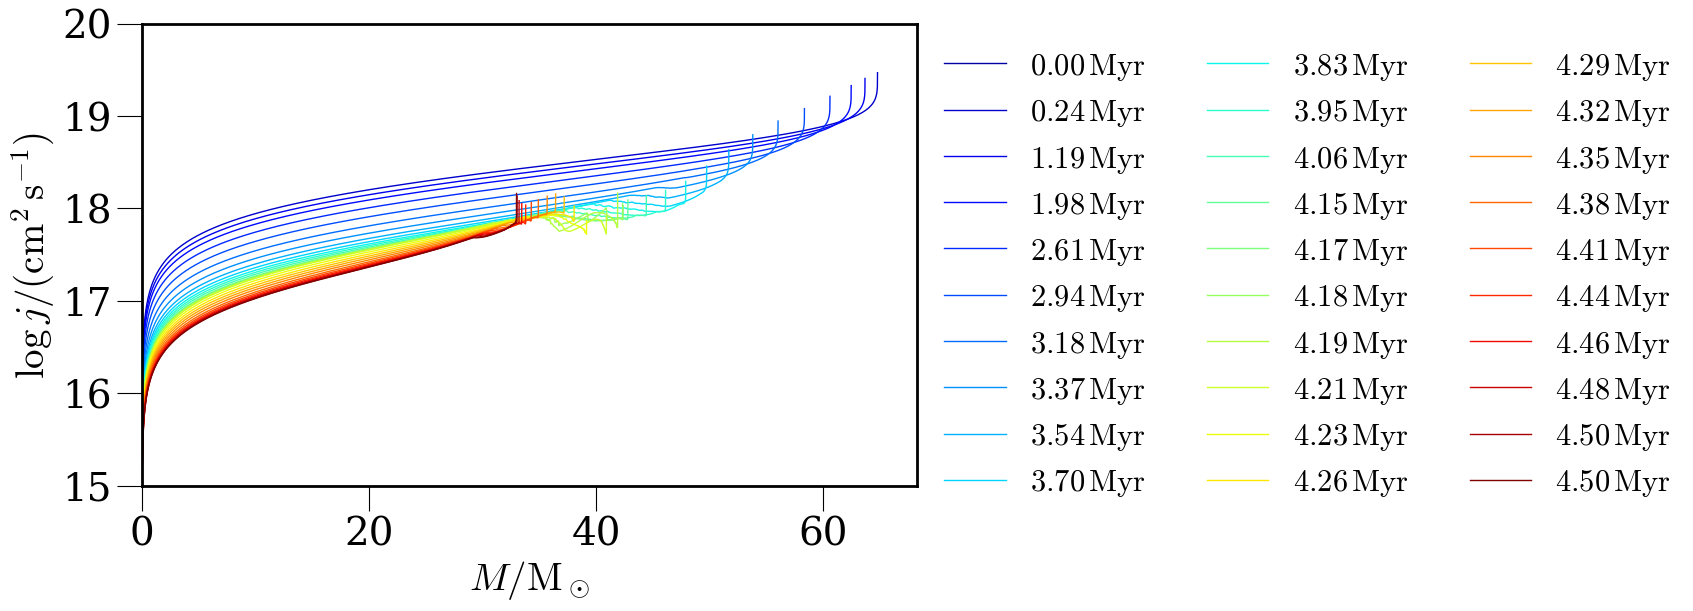

In [122]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_j_rot, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log j/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
ax.set_ylim(15, 20)
ax.set_xlim(0)
    

(0.0, 68.01282092273708)

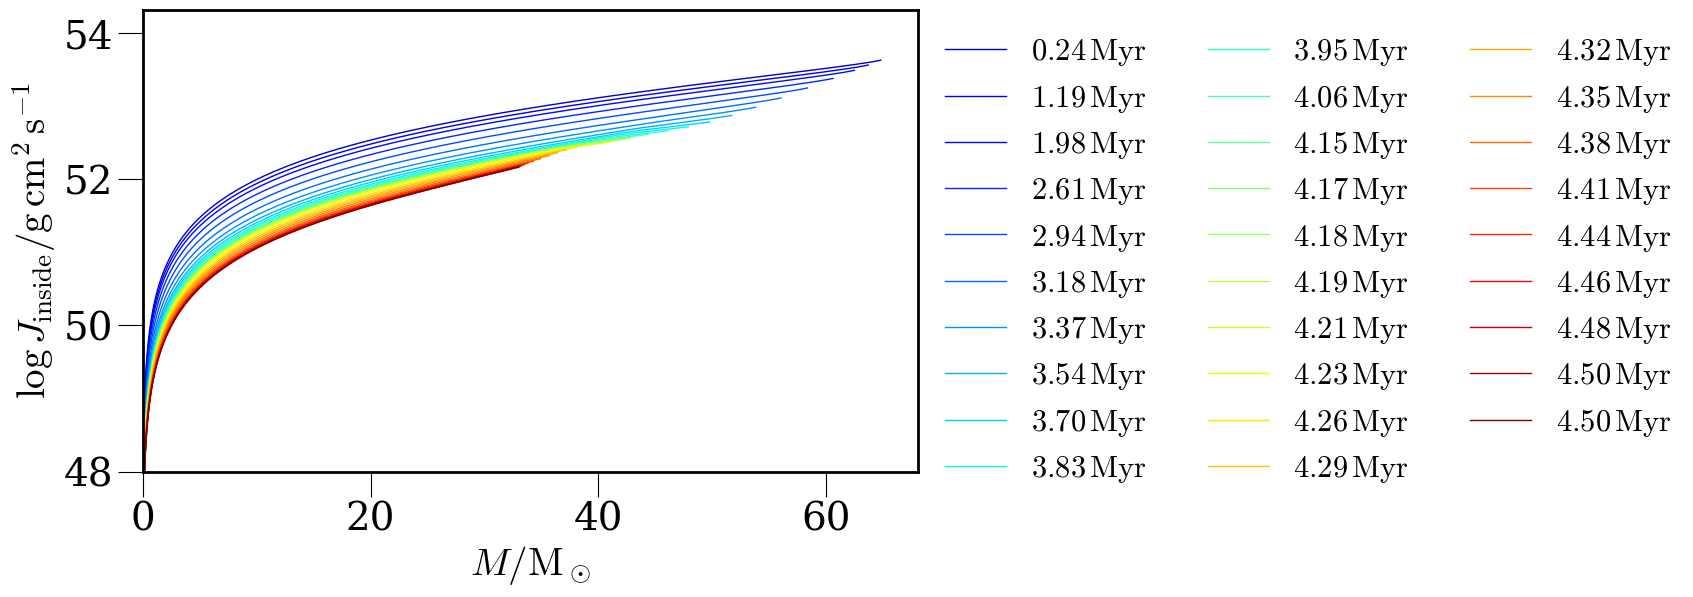

In [165]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[1:]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_J_inside, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log J_\\mathrm{inside}/\\mathrm{g}\\,\\mathrm{cm}^2\\,\\mathrm{s}^{-1}$')
ax.set_ylim(48)
ax.set_xlim(0)
    

(0.0, 68.24999812351741)

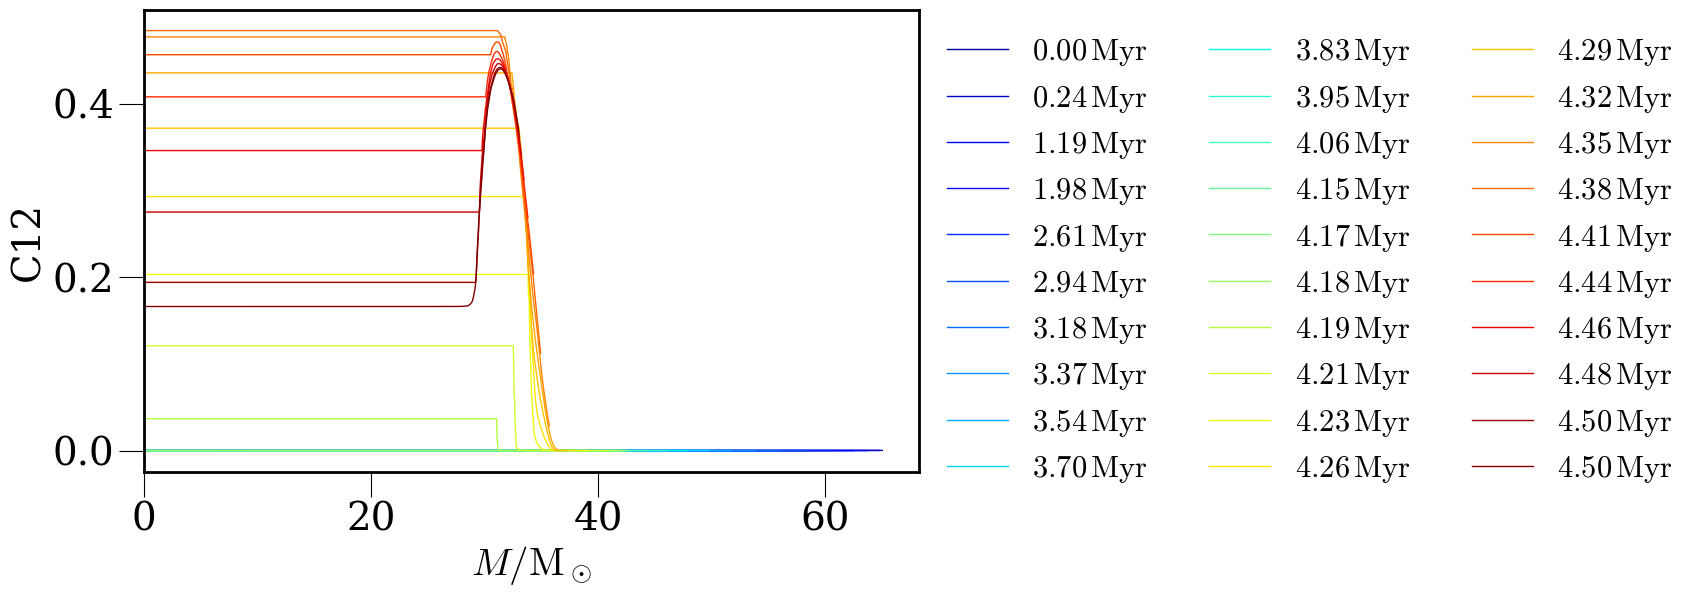

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.c12, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('C12')
#ax.set_ylim(15, 20)
ax.set_xlim(0)
    

In [173]:
test_case = model_dicts[0]['65.0']['1.19']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(0.0, 68.24999812583178)

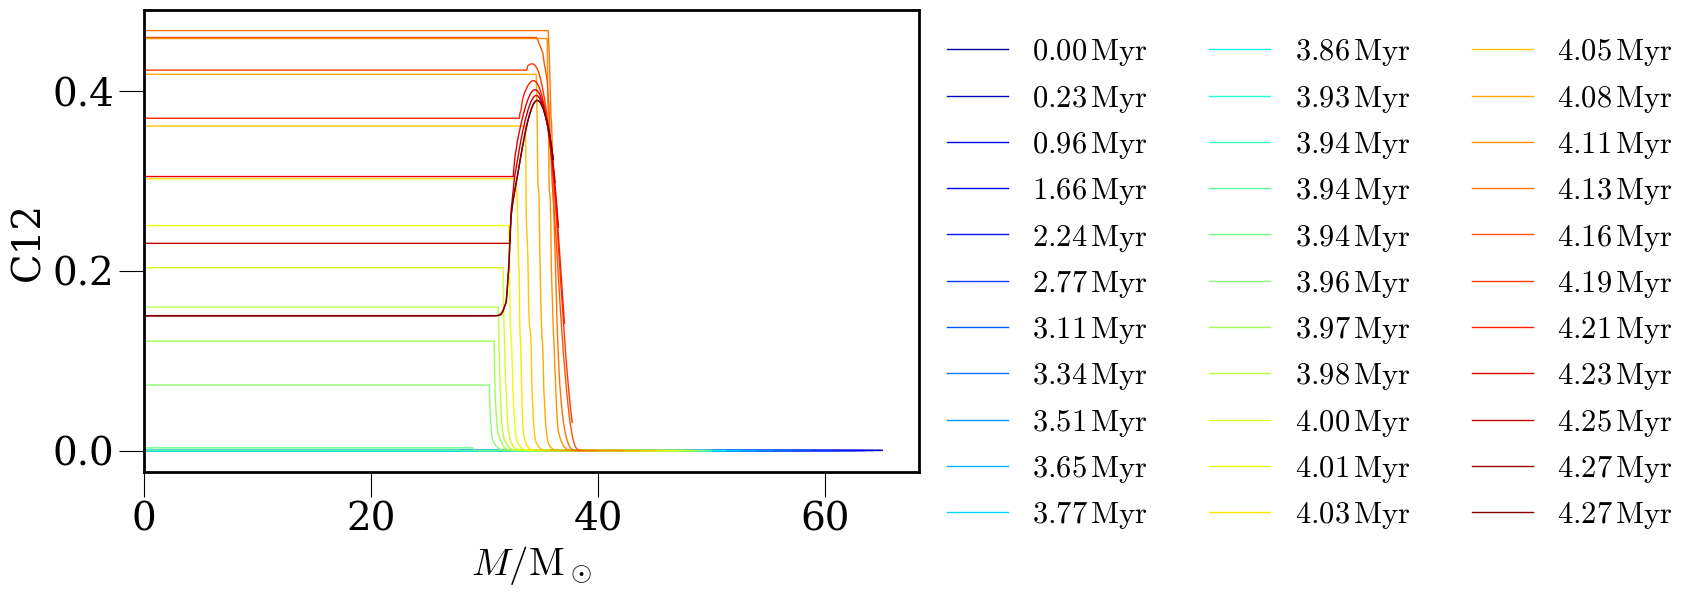

In [174]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.c12, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('C12')
#ax.set_ylim(15, 20)
ax.set_xlim(0)
    

In [185]:
def get_co_core_mass_log_am(logs):
    profiles_central_c12 = [logs.profile_data(profile_number=n).c12[-1] for n in logs.profile_numbers]
    print(profiles_central_c12)
    max_co_prof_index = np.argmax(profiles_central_c12)
    print(max_co_prof_index)
    prof = logs.profile_data(profile_number=logs.profile_numbers[max_co_prof_index])
    co_core_edge_index = np.where(prof.c12 >= prof.c12[-1])[0][0]
    print(co_core_edge_index)
    core_log_am = prof.log_J_inside[co_core_edge_index]
    core_mass = prof.mass[co_core_edge_index]
    return core_mass, core_log_am

def get_core_mass_spin(logs):
    mass, log_am = get_co_core_mass_log_am(logs)
    mass *= ct.M_sun.cgs
    am = 10.**log_am * u.g * u.cm**2 / u.s
    x = ct.c.cgs * am / (ct.G.cgs * mass**2)
    return mass.to(u.Msun).value, x.value

In [186]:
test_case = model_dicts[0]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

[1.2387957118543941e-05, 1.51679926370778e-05, 1.5835423109702134e-05, 1.6302951333411693e-05, 1.67854645503059e-05, 1.709564684305513e-05, 1.7365482514462417e-05, 1.7637034486882097e-05, 1.7942921567885323e-05, 1.8301950754352857e-05, 1.8742780564141844e-05, 1.9322811107791598e-05, 2.0199728916740515e-05, 2.2531280667364826e-05, 3.066813497636385e-05, 7.763463909841786e-05, 0.03679067827701539, 0.12085761039504718, 0.20310744272842385, 0.2929513348086674, 0.3717826533844479, 0.43558702907055913, 0.4770539280350472, 0.4843421339976364, 0.45651034262965196, 0.40792381867825317, 0.34597962765657364, 0.27507817155260633, 0.19403032770563597, 0.16616244062593014]
23
1540


(31.068076084867258, 1.6394946135760102)

In [170]:
test_case = model_dicts[1]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(38.26660173470028, 1.6027570716286137)

In [168]:
test_case = model_dicts[0]['65.0']['1.00']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(31.449711375425565, 1.6553683374278423)

In [171]:
test_case = model_dicts[1]['65.0']['1.00']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(38.421556671758786, 1.6100302776775735)

In [169]:
test_case = model_dicts[0]['65.0']['1.19']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(1.9858970714481876e-06, 517.5124839271701)

In [172]:
test_case = model_dicts[1]['65.0']['1.19']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(2.4751109590993666e-06, 536.1140887424672)

## The effect of mass

(5.2, 6.4)

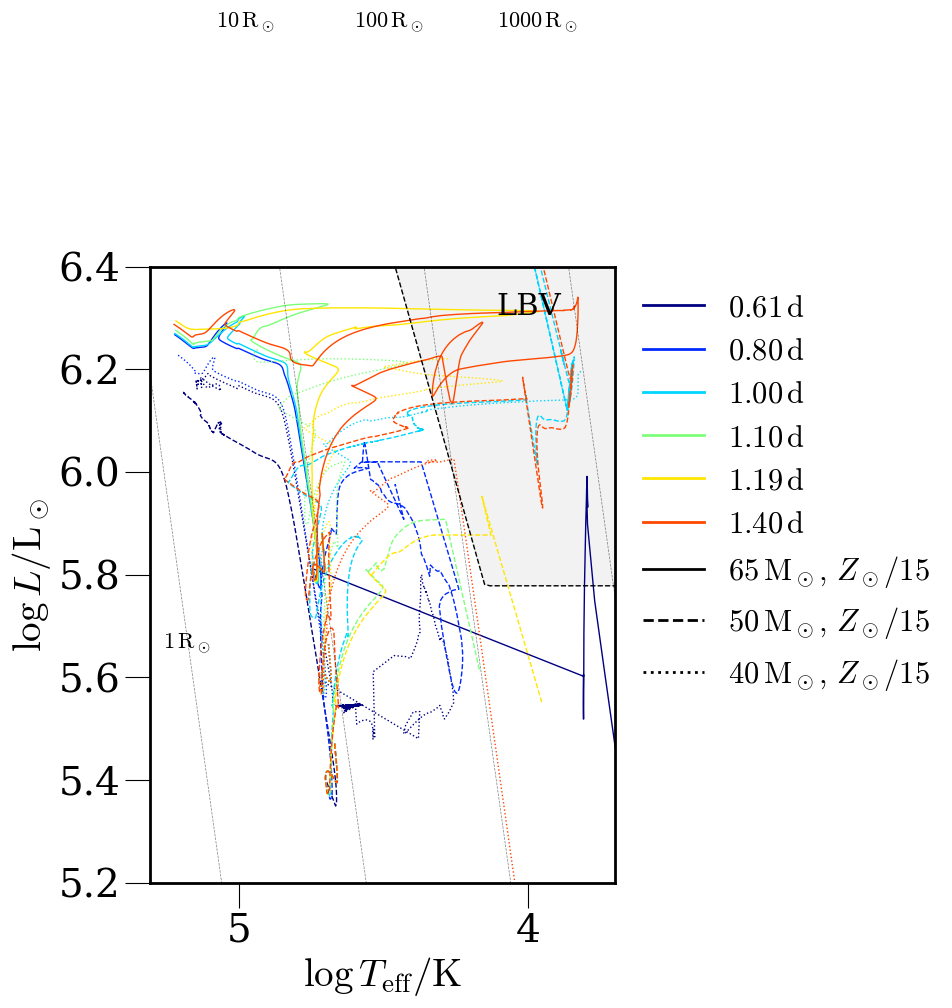

In [178]:

fig, ax = plt.subplots(figsize=(6, 8))

# Plot 1, Zsun/10

models_to_plot = [1, 3, 2]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)



ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

# GUIDELINES

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Humphreys-Davidson limit and LBV regime
hd_x = np.linspace(*xlim, 100)
hd_y = hd_limit(hd_x)
ax.plot(hd_x, hd_y, 'k--', lw=1)
ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)
ax.text(4, 6.35, 'LBV', ha='center', va='top', fontsize=22, transform=ax.transData)

# Lines of constant radius
r = 1
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-5.7))], 5.7-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='top', fontsize=16)
r = 10
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 100
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)
r = 1000
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)

ax.set_xlim(xlim[0], 3.7)
ax.set_ylim(5.2, 6.4)

#savefig(fig, 'hr_allp_metallicity_comparison')

In [179]:
test_case = model_dicts[1]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(38.26660173470028, 1.6027570716286137)

In [183]:
test_case = model_dicts[3]['40.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(1.8471726311821023e-06, 1156.8581348169766)

In [184]:
test_case = model_dicts[2]['50.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers
get_core_mass_spin(logs)

(1.9665352018023e-06, 515.0197113511591)